In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import optimize
import constants as c

%matplotlib inline

In [7]:
def V_morse(x):
    D = 0.1744 # 4.7457 eV
    beta = 1.02764 # 1.94196e10 m-1
    x_e = 1.40201 # 0.74191e-10 m

    return D*(1-np.exp(-beta*(x-x_e)))**2

def V_ho(x):
    return 0.5*x**2

def V_lj(x):
    C6 = 1394
    De = 334
    C12 = C6**2/(4*De)
    return C12/x**12 - C6/x**6
    
    
def fgh(V, x_grid, m):
    
    N = x_grid.size
    delta_x = x_grid[1] - x_grid[0]
    xmax = x_grid[-1]

    H = np.zeros((N,N))

    T_k = np.zeros(N)
    for n in range(0,N):
        T_k[n] = 2/m * (np.pi*(n-(N-1)/2.0)/(xmax))**2
    T_k = np.fft.fftshift(T_k)

    for n in range(0,N):

        phi_n = np.zeros(N)
        phi_n[n] = 1

        V_phi_n = np.zeros(N)
        V_phi_n[n] = V(x_grid[n])

        # fast fourier transform
        F_phi_n = np.fft.fft(phi_n) # into k-space
        TF_phi_n = np.multiply(T_k, F_phi_n)
        T_phi_n = np.fft.ifft(TF_phi_n) # not sure if this is necessary

        H[:,n] = T_phi_n + V_phi_n

    # diagonalize
    E, psi = np.linalg.eig(H)
    E = np.real(E)

    # sort energies in increasing order
    ind = np.argsort(E)
    E = E[ind]
    psi = psi[:,ind]

    print(E[0:20])
    
    plt.plot(x_grid,psi[:,5])


In [3]:
def regrid(x_min, x_max, N, A, beta):
    
    x_mapping = lambda Q: x_min + Q - A * np.arctan(beta*Q)
        
    Q_max = sp.optimize.root(lambda Q: x_mapping(Q)-x_max,1.0).x
    Q_min = 0
    
    Q = np.linspace(Q_min, Q_max, N)
    #plt.plot(Q,x_mapping(Q))
    
    J = 1 - A * beta / (1 + (beta * Q)**2)
    
    return Q, J, x_mapping(Q)

def fgh_scaled(V, x_grid, x_coord, J, m):
    
    J_inv = J**(-1)
    
    N = x_grid.size
    delta_x = x_grid[1] - x_grid[0]
    xmax = x_grid[-1] - x_grid[0]

    H = np.zeros((N,N))

    T_k = np.zeros(N)
    for n in range(0,N):
        T_k[n] = n-(N-1)/2.0 # np.sqrt(2/m * (np.pi*(n-(N-1)/2.0)/(xmax))**2)
    T_k = np.fft.fftshift(T_k)

    for n in range(0,N):

        phi_n = np.zeros(N)
        phi_n[n] = 1

        V_phi_n = np.zeros(N)
        V_phi_n[n] = V(x_coord[n])

        # fast fourier transform
        F_phi_n = np.fft.fft(phi_n) # into k-space     
        
        dphi_dq = np.multiply(J_inv, np.fft.ifft(np.multiply(T_k, F_phi_n)))
        F_dphi_dq = np.fft.fft(dphi_dq)
        dphi_dq2 = np.multiply(J_inv, np.fft.ifft(np.multiply(T_k, F_dphi_dq)))
        T_phi_n = dphi_dq2 * 2/m * (np.pi/(xmax))**2

        H[:,n] = T_phi_n + V_phi_n

    # diagonalize
    E, psi = np.linalg.eig(H)
    E = np.real(E)

    # sort energies in increasing order
    ind = np.argsort(E)
    E = E[ind]
    psi = psi[:,ind]

    print(E[0:20])
    #plt.plot(E[0:20])
    
    plt.plot(x_coord,-psi[:,5])


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:46: ComplexWarning: Casting complex values to real discards the imaginary part


[ 0.04784868  0.11287437  0.1782184   0.24372093  0.3093218   0.37499093
  0.44071078  0.50647008  0.5722611   0.63807824  0.70391729  0.76977501
  0.83564882  0.90153664  0.96743674  1.03334769  1.09926826  1.1651974
  1.2311342   1.29707786]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:44: ComplexWarning: Casting complex values to real discards the imaginary part


[ 0.04781022  0.11283291  0.17817489  0.24367583  0.3092754   0.37494343
  0.44066233  0.50642081  0.57221109  0.63802757  0.70386603  0.76972322
  0.83559654  0.90148392  0.96738361  1.03329418  1.09921441  1.16514323
  1.23107974  1.29702313]


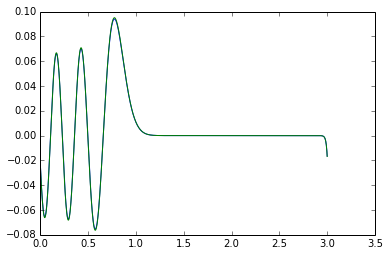

In [15]:
x_grid = np.linspace(0,3,1000)

Q_grid, J, x_coord = regrid(0,3,1000,9.9,0.05)

#fgh_scaled(V_morse,x_grid,x_grid,np.ones(x_grid.size),1822/2.0)
fgh_scaled(V_ho,Q_grid,x_coord,J,1822/2.0)
fgh(V_ho,x_grid,1822/2.0)

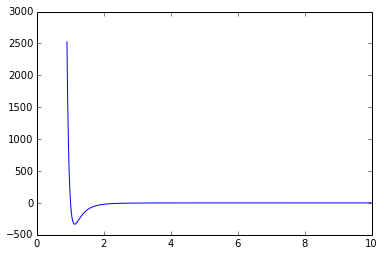

In [13]:
x_grid = np.linspace(0.9,10,1000)
plt.plot(x_grid,V_lj(x_grid))

In [50]:
def V_ho_SI(x,m,omega):
    return 0.5*m*omega*x**2

def fgh_scaled_SI(V, x_grid, x_coord, J, m):
    
    J_inv = J**(-1)
    
    N = x_grid.size
    delta_x = x_grid[1] - x_grid[0]
    xmax = x_grid[-1] - x_grid[0]

    H = np.zeros((N,N))

    T_k = np.zeros(N)
    for n in range(0,N):
        T_k[n] = n-(N-1)/2.0 # np.sqrt(2/m * (np.pi*(n-(N-1)/2.0)/(xmax))**2)
    T_k = np.fft.fftshift(T_k)

    for n in range(0,N):

        phi_n = np.zeros(N)
        phi_n[n] = 1

        V_phi_n = np.zeros(N)
        V_phi_n[n] = V(x_coord[n])

        # fast fourier transform
        F_phi_n = np.fft.fft(phi_n) # into k-space     
        
        dphi_dq = np.multiply(J_inv, np.fft.ifft(np.multiply(T_k, F_phi_n)))
        F_dphi_dq = np.fft.fft(dphi_dq)
        dphi_dq2 = np.multiply(J_inv, np.fft.ifft(np.multiply(T_k, F_dphi_dq)))
        T_phi_n = dphi_dq2 * 2/m * (c.hbar*np.pi/(xmax))**2

        H[:,n] = T_phi_n + V_phi_n

    # diagonalize
    E, psi = np.linalg.eig(H)
    E = np.real(E)

    # sort energies in increasing order
    ind = np.argsort(E)
    E = E[ind]
    psi = psi[:,ind]

    print(E[0:20])
    #plt.plot(E[0:20])
    
    plt.plot(x_coord,-psi[:,0])
    plt.plot(x_coord,-psi[:,1])
    plt.plot(x_coord,-psi[:,2])



/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:35: ComplexWarning: Casting complex values to real discards the imaginary part


[  1.48075093e-34   3.53887270e-34   5.61023047e-34   7.68823545e-34
   9.77040021e-34   1.18554786e-33   1.39427431e-33   1.60317259e-33
   1.81221052e-33   2.02136486e-33   2.23061817e-33   2.43995697e-33
   2.64937061e-33   2.85885046e-33   3.06838944e-33   3.27798165e-33
   3.48762212e-33   3.69730660e-33   3.90703143e-33   4.11679344e-33]


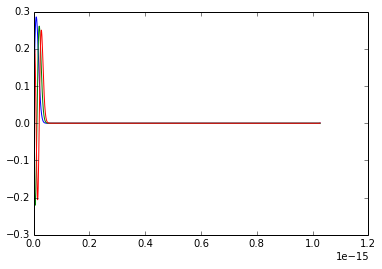

In [57]:
Q_grid, J, x_coord = regrid(0,100*np.sqrt(c.hbar),1000,9.9,0.1)
x_grid = np.linspace(0,100*np.sqrt(c.hbar),1000)

fgh_scaled_SI(lambda x:V_ho_SI(x,1.0,1.0),x_grid,x_grid,np.ones(x_grid.size),1.0)
#fgh_scaled_SI(lambda x:V_ho_SI(x,2.0,1.0/c.hbar),x_grid,2.0)

In [24]:
c.hbar

1.0545716279999998e-34

In [ ]:
R0 = 0
Rmax = 1e-6
N = 1000
grid = fgh.grid(R0, Rmax, N, coord_maps)

sol = fgh.solve(V, m, grid, units='SI') #si or au





In [1]:
import fgh

In [65]:
system.units

'a.u.'

In [11]:
import fgh
import numpy as np
import constants as c
A = 9.9
beta = 0.1
x_mapping = lambda Q: Q - A * np.arctan(beta*Q)
dx_mapping = lambda Q: 1 - A * beta / (1 + (beta * Q)**2)
def V_ho_SI(x,m,omega):
    return 0.5*m*omega*x**2
grid = fgh.grid(0,100,1000,x_mapping,dx_mapping)
prob = fgh.problem(lambda x: V_ho_SI(x,1.0,1.0),1.0,units='SI')

sol2 = fgh.solve(prob,grid)


[  6.29687839e-63   6.64750232e-07   2.72851239e-06   6.40413663e-06
   1.20607178e-05   2.02449783e-05   3.17109353e-05   4.74575867e-05
   6.87742839e-05   9.72933870e-05   1.35049742e-04   1.84546462e-04
   2.48826441e-04   3.31548991e-04   4.37070954e-04   5.70531604e-04
   7.37940644e-04   9.46268583e-04   1.20353876e-03   1.51892031e-03]


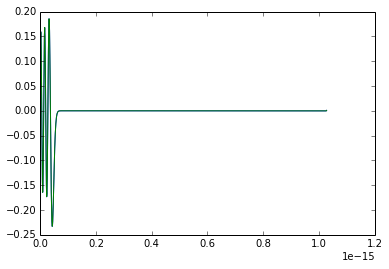

In [6]:
plt.plot(sol.x,sol.psi[:,5])
plt.plot(sol2.x,sol2.psi[:,5])

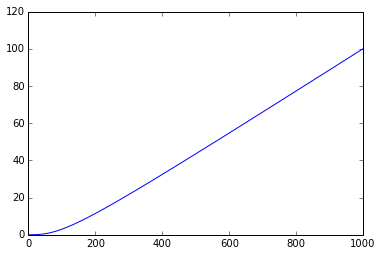

In [12]:
plt.plot(sol2.x)

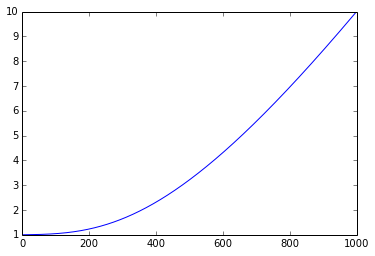

In [13]:
A, beta = 9.9, 0.1
x_mapping = lambda Q: Q - A * np.arctan(beta*Q)
dx_mapping = lambda Q: 1 - A * beta / (1 + (beta * Q)**2)
grid = fgh.grid(1,10,1000,x_mapping,dx_mapping)
plt.plot(grid.q)